In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('./src')
sys.path.append('..')

In [3]:
from src.data.toy import (
    DiscreteGaussianDataset, 
    DiscreteSwissRollDataset, 
    DiscreteUniformDataset,
)
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
from tqdm.notebook import tqdm
import wandb
from PIL import Image
import numpy as np

from src.methods.light_sb_d import LightSB_D
from src.utils.visualization import fig2img, plot_samples
from src.benchmark.benchmark import BenchmarkDiscreteEOT

In [4]:
DIM            = 2
NUM_CATEGORIES = 200
NUM_POTENTIALS = 4
D_LR           = 1e-4
DEVICE         = 'cpu'
BATCH_SIZE     = 512
N_EPOCHS       = 200000
PRIOR_TYPE     = 'gaussian_log'
P0             = 'gaussian'
EXP_TYPE       = 'benchmark'
DIST_INIT      = 'gaussian'
NUM_STEPS      = 16
NUM_SKIP_STEPS = 8
wandb_report   = False

if PRIOR_TYPE == 'uniform':
    BETAS        = [0.01, 0.005]
elif PRIOR_TYPE in ['gaussian_log', 'gaussian']:
    BETAS        = [0.02, 0.05]
    
config = dict(DIM            = DIM,
              NUM_CATEGORIES = NUM_CATEGORIES,
              NUM_POTENTIALS = NUM_POTENTIALS,
              D_LR           = D_LR,
              DEVICE         = DEVICE,
              BATCH_SIZE     = BATCH_SIZE,
              BETA           = BETAS, 
              PRIOR_TYPE     = PRIOR_TYPE,
              NUM_STEPS      = NUM_STEPS,
              NUM_SKIP_STEPS = NUM_SKIP_STEPS,
              N_EPOCHS       = N_EPOCHS)

if wandb_report:
    wandb_mode = 'online' #'disabled'
else:
    wandb_mode = 'disabled'



  0%|          | 0/200000 [00:00<?, ?it/s]

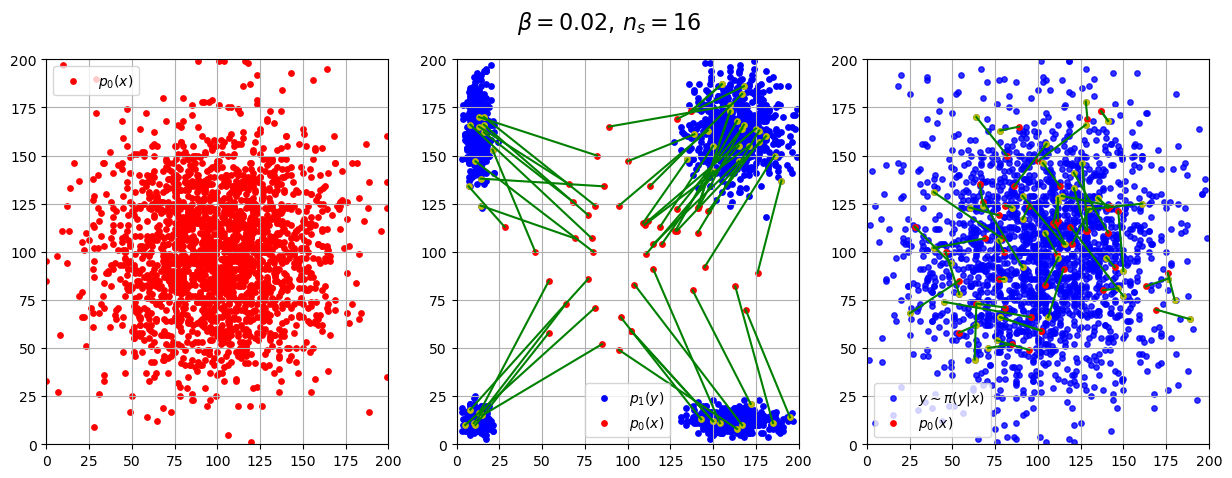

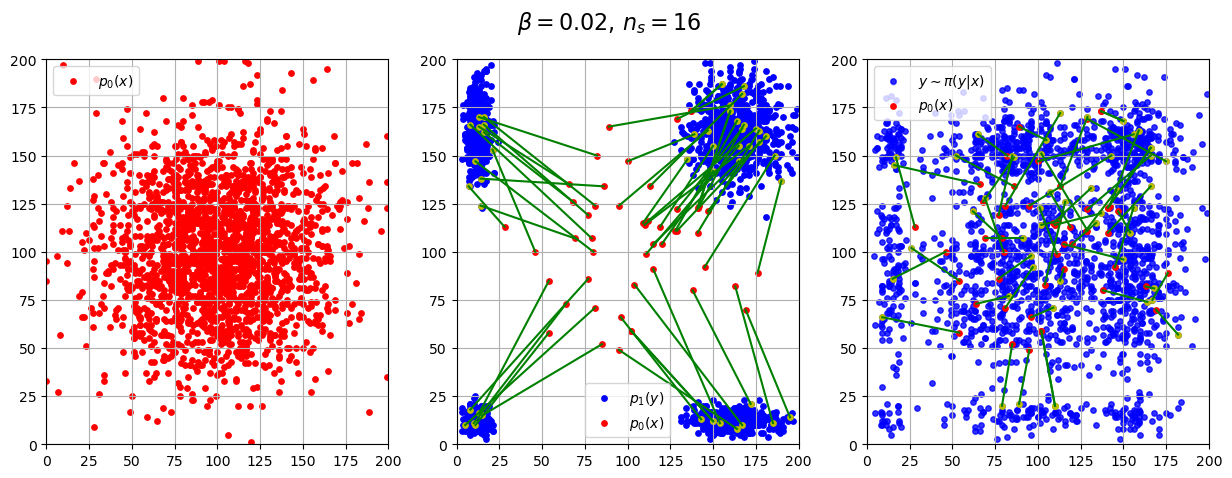

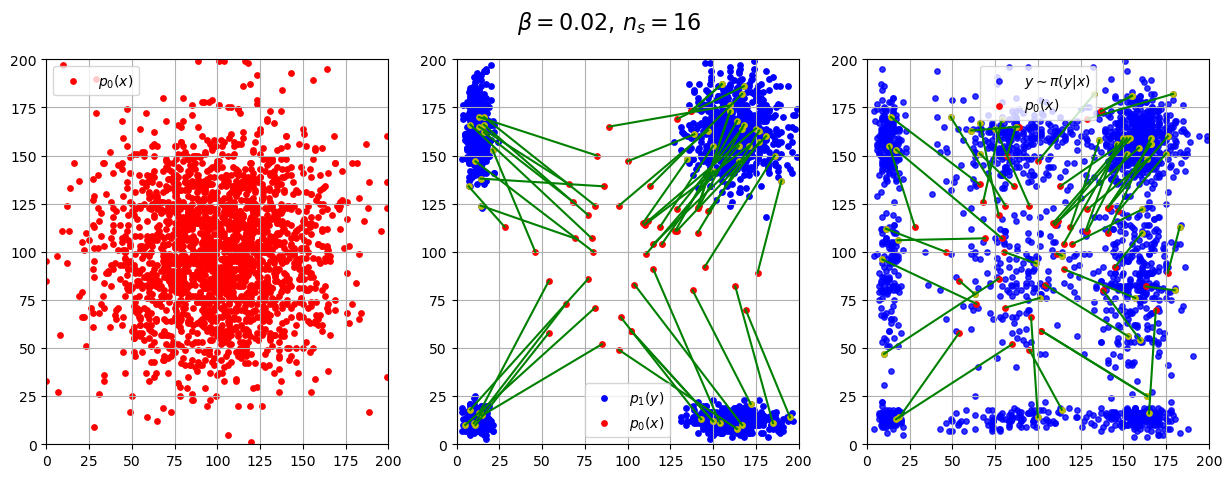

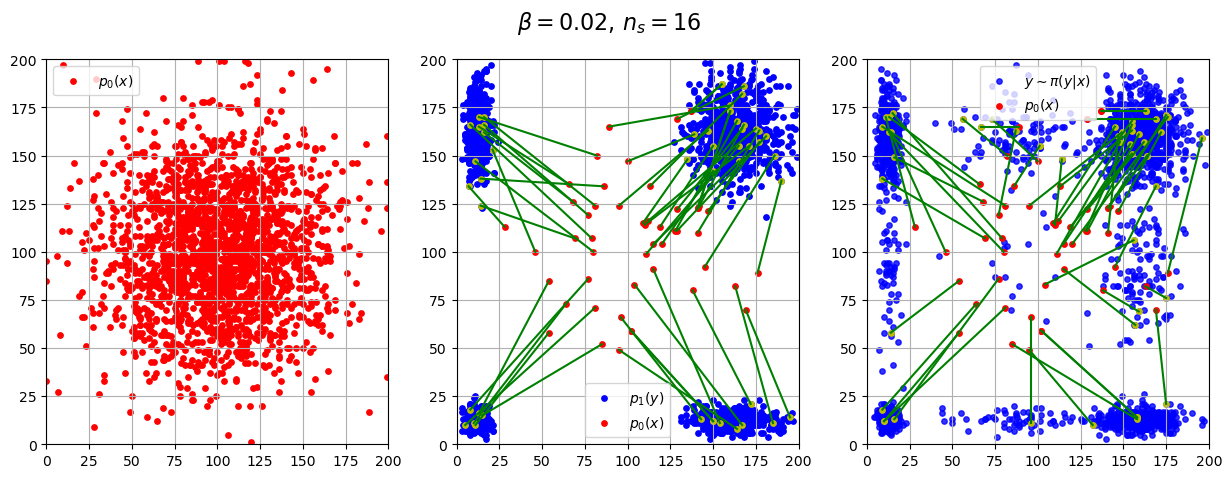

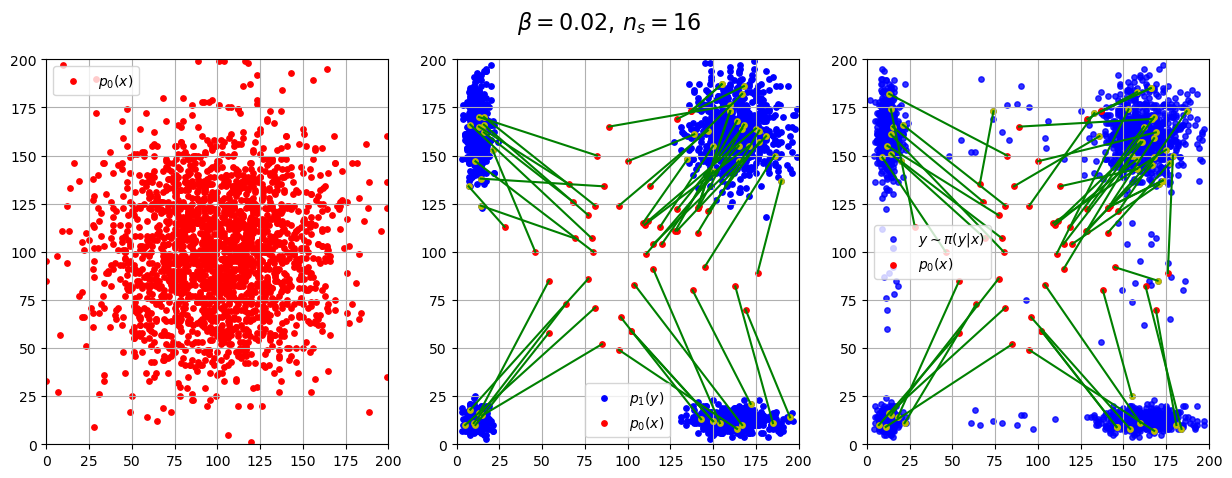

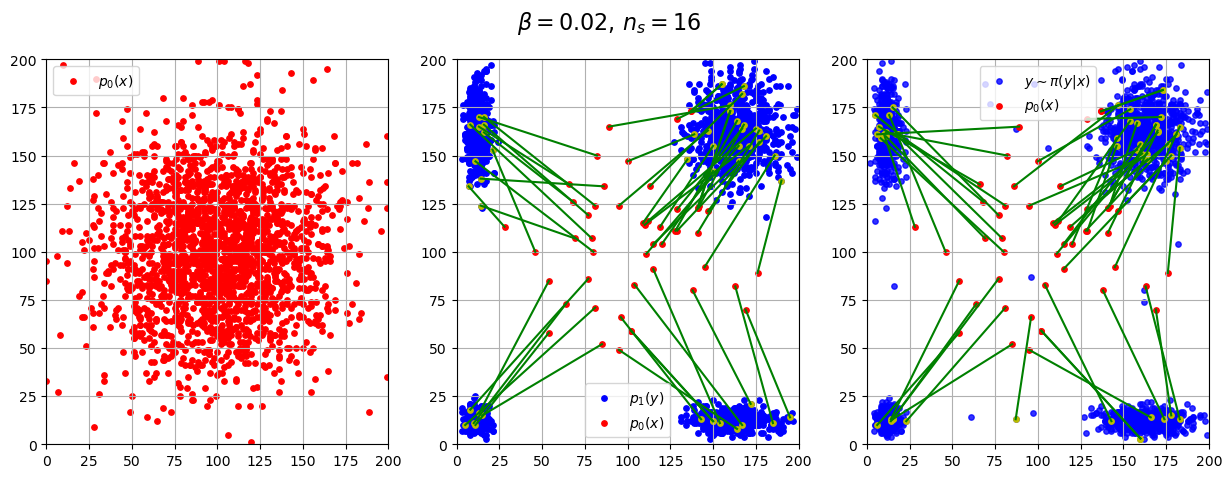

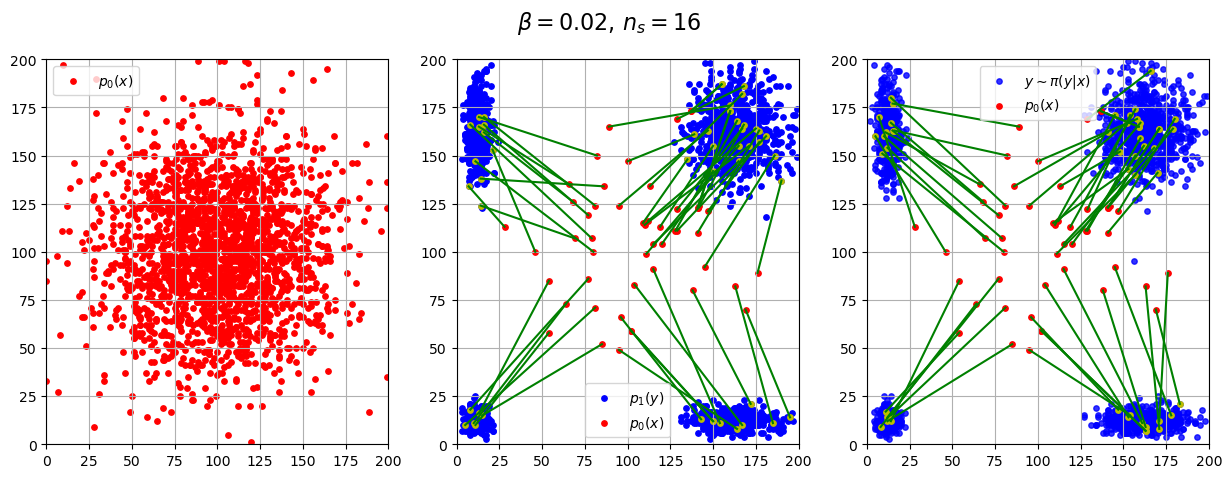

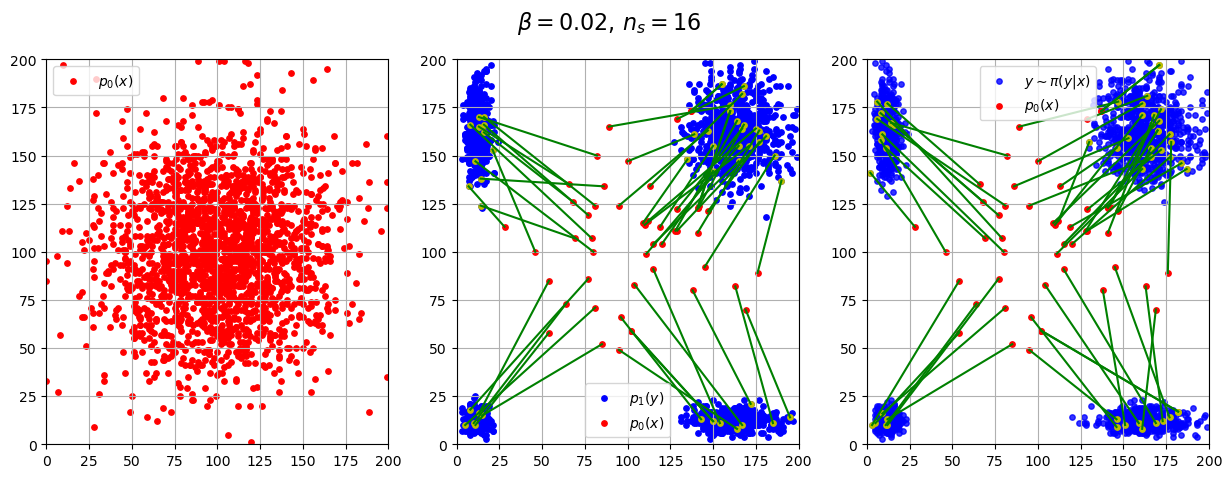

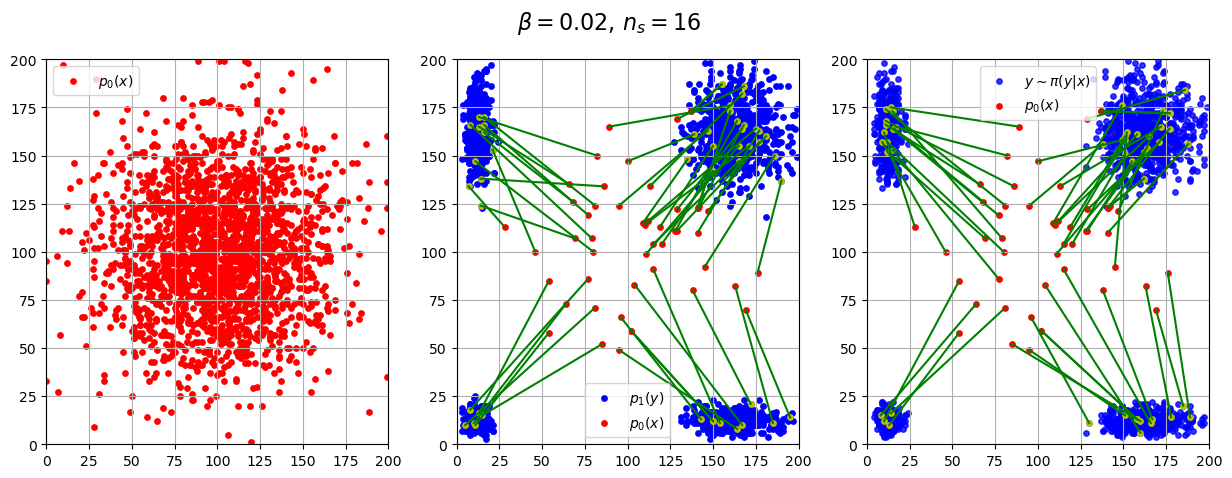

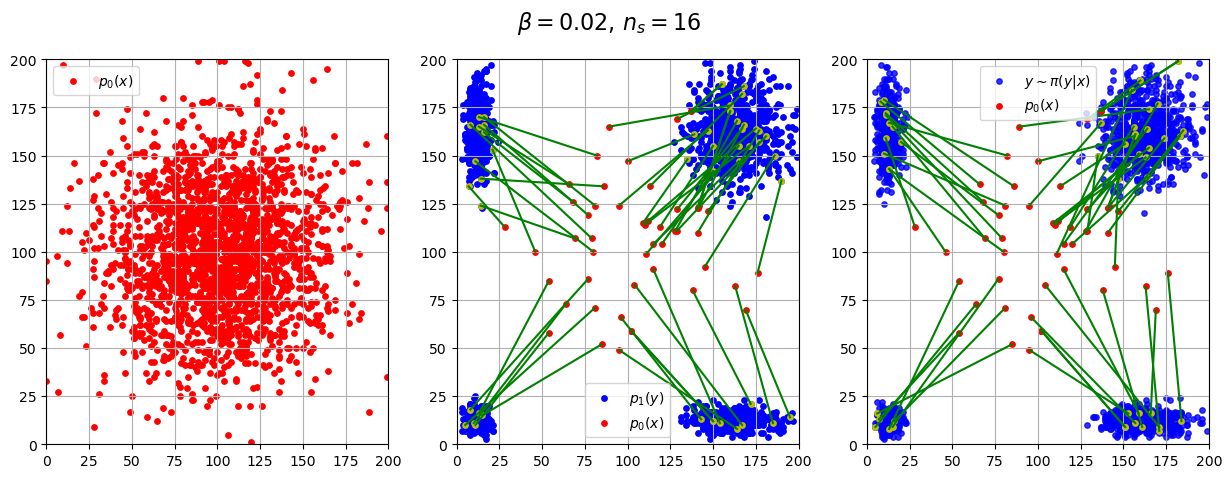

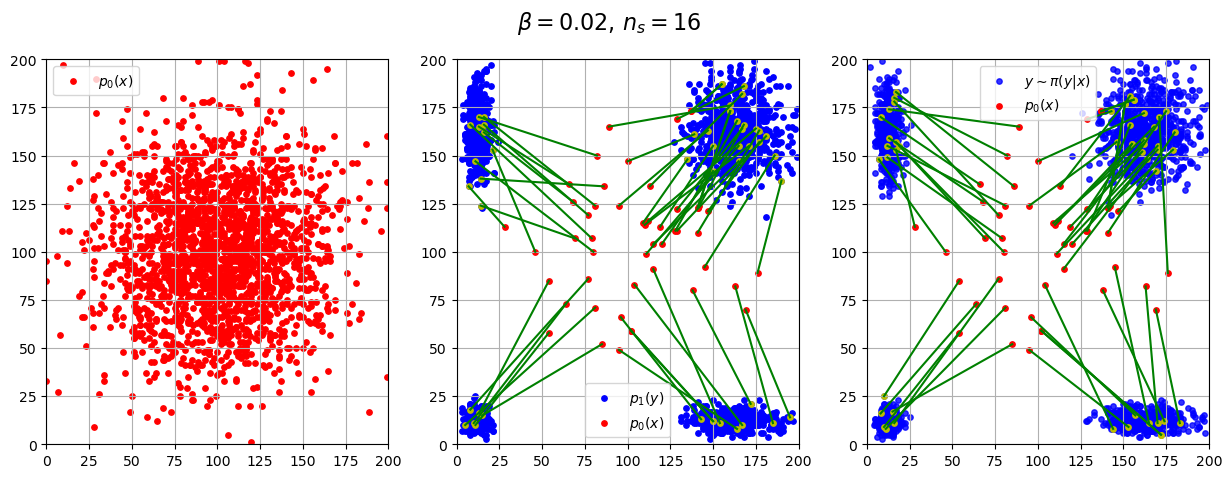

  0%|          | 0/200000 [00:00<?, ?it/s]

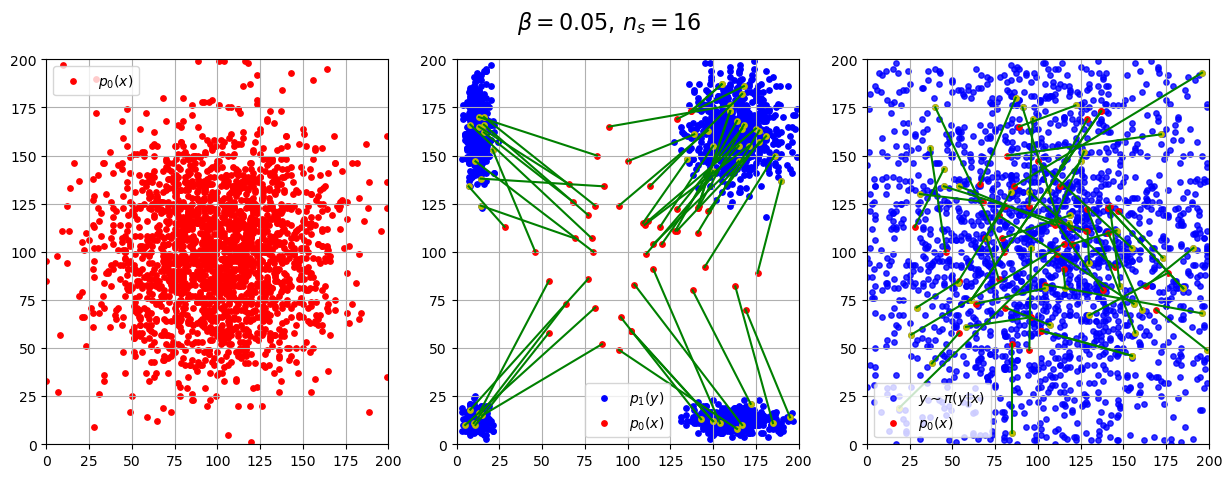

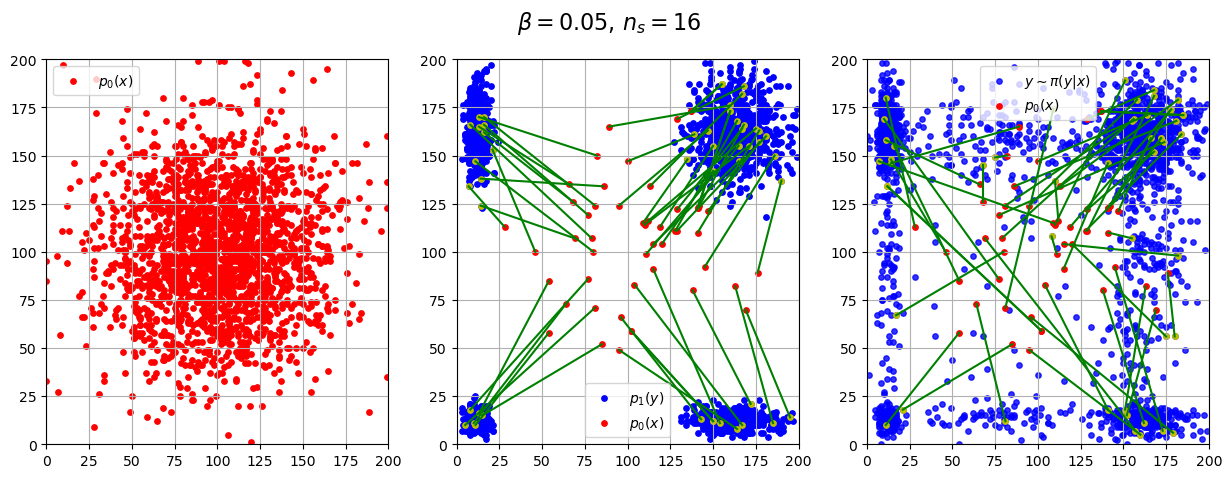

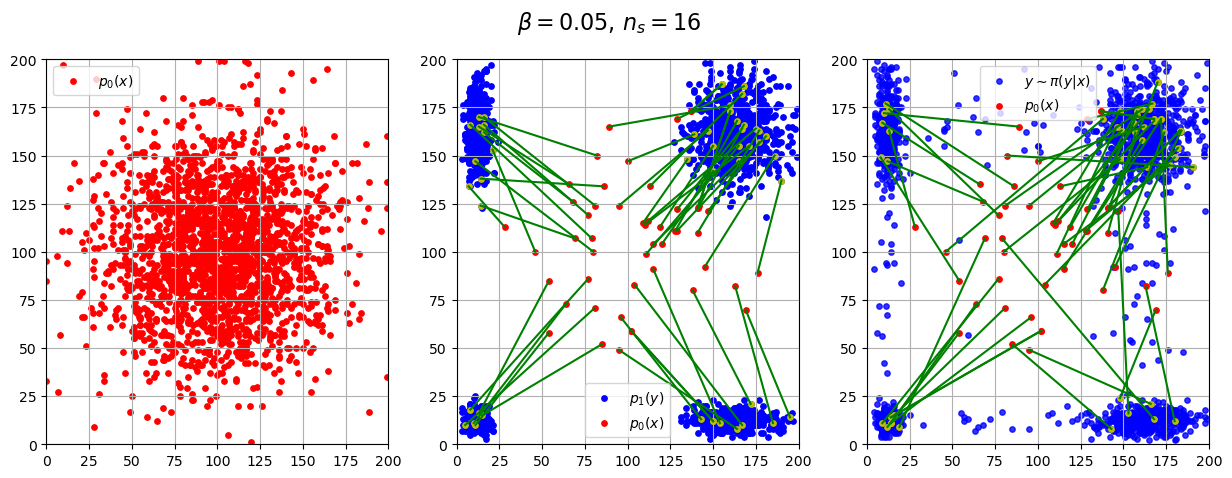

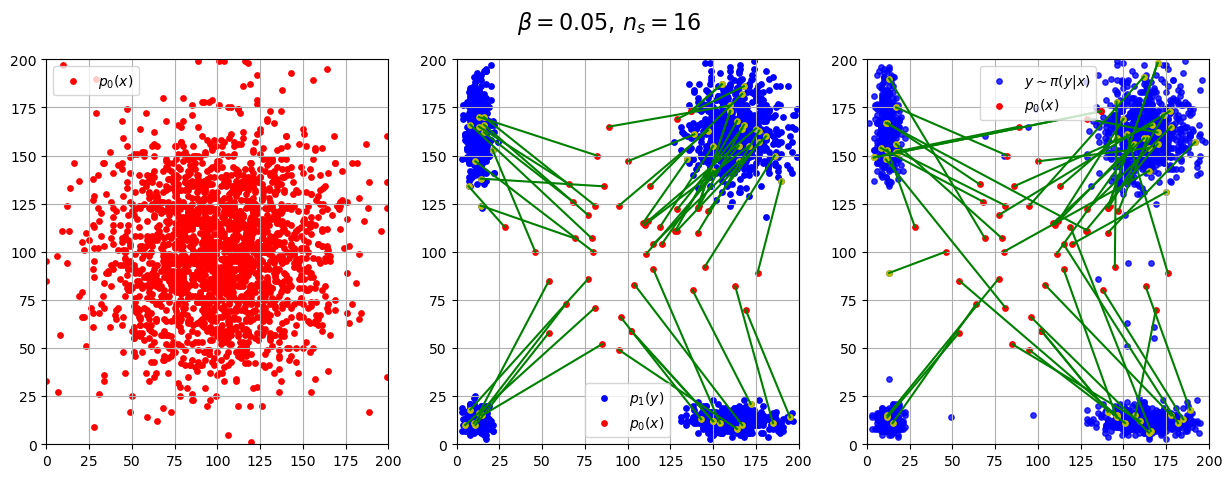

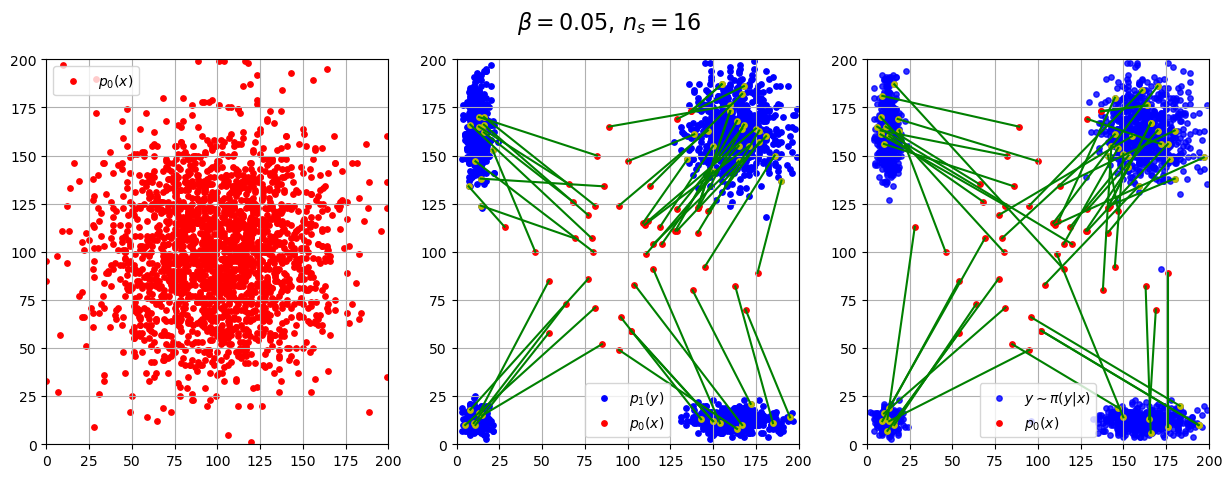

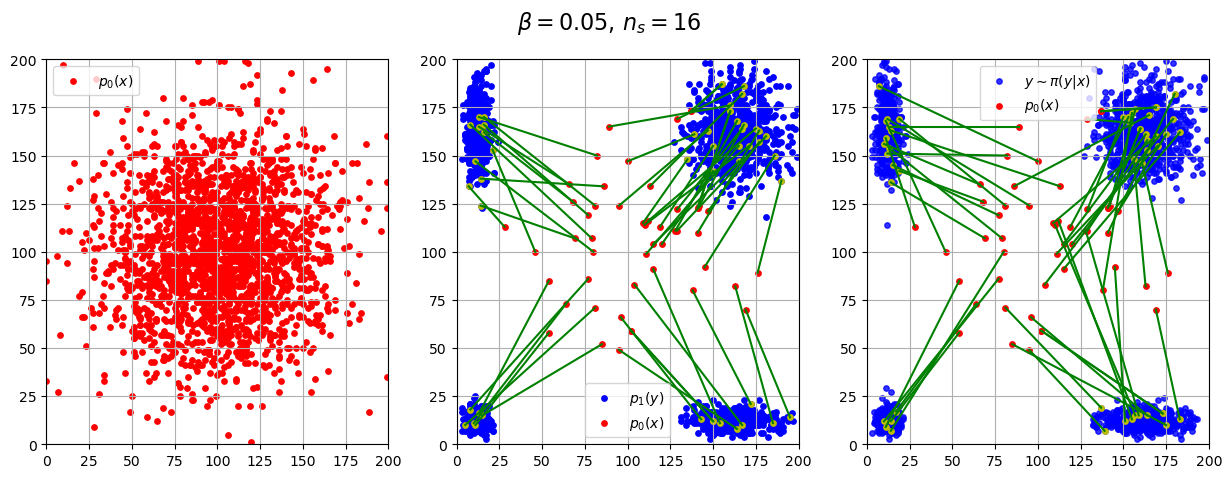

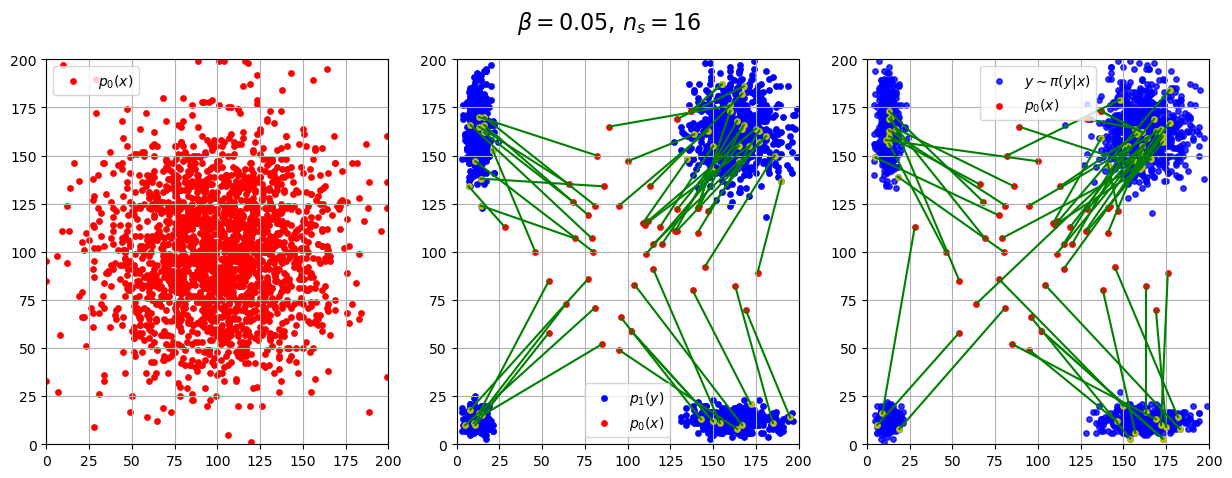

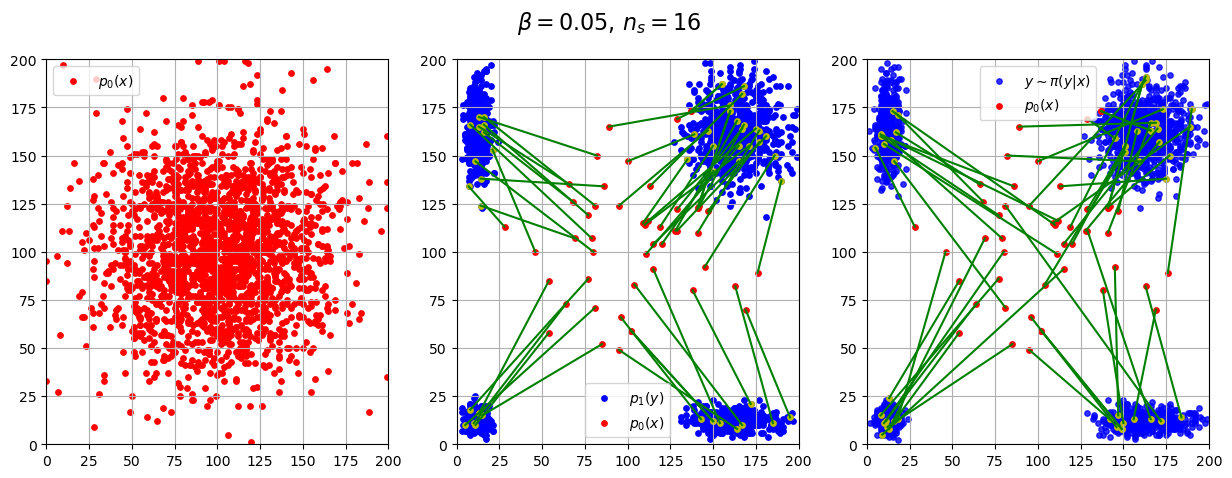

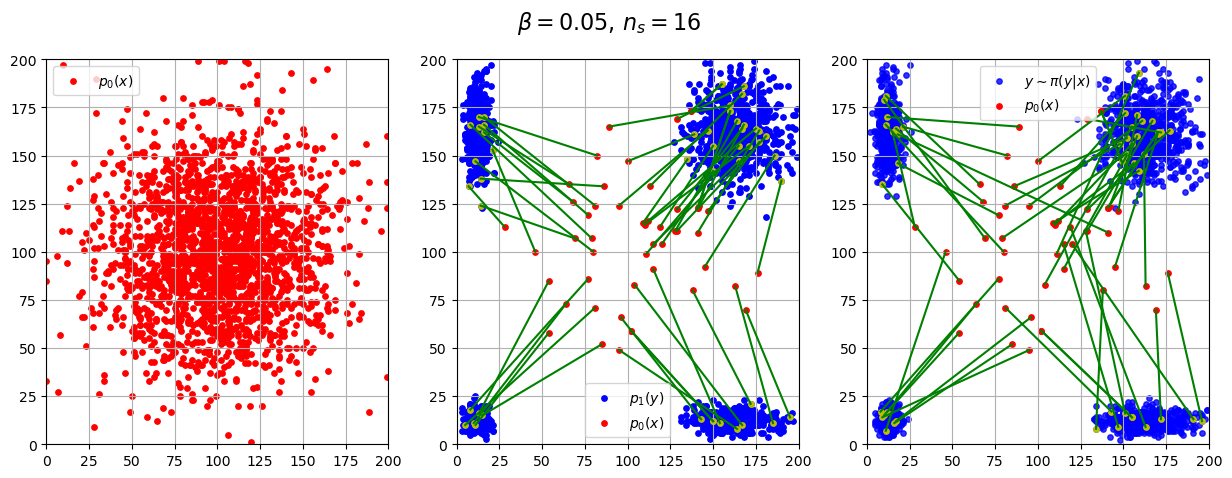

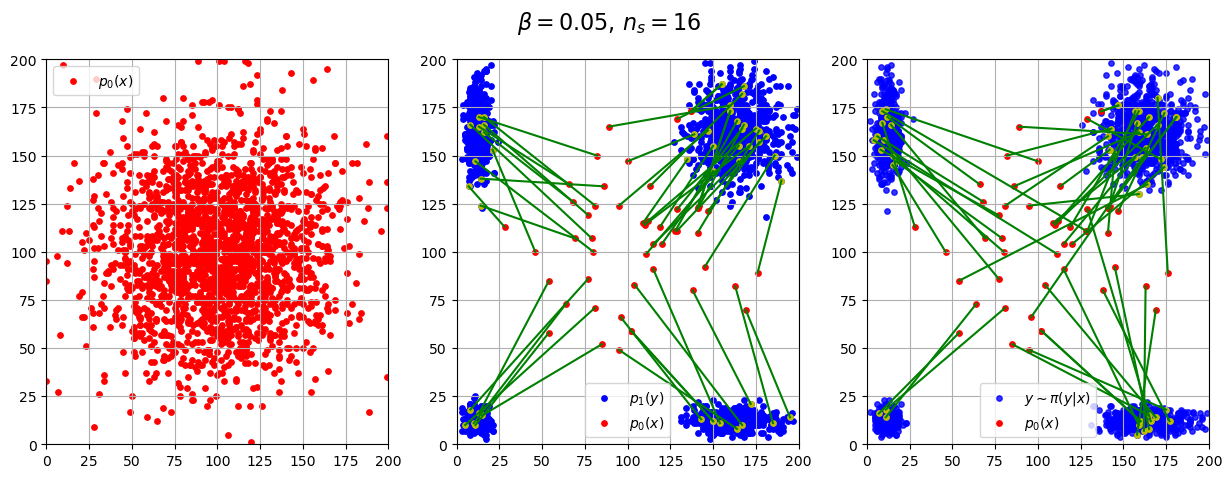

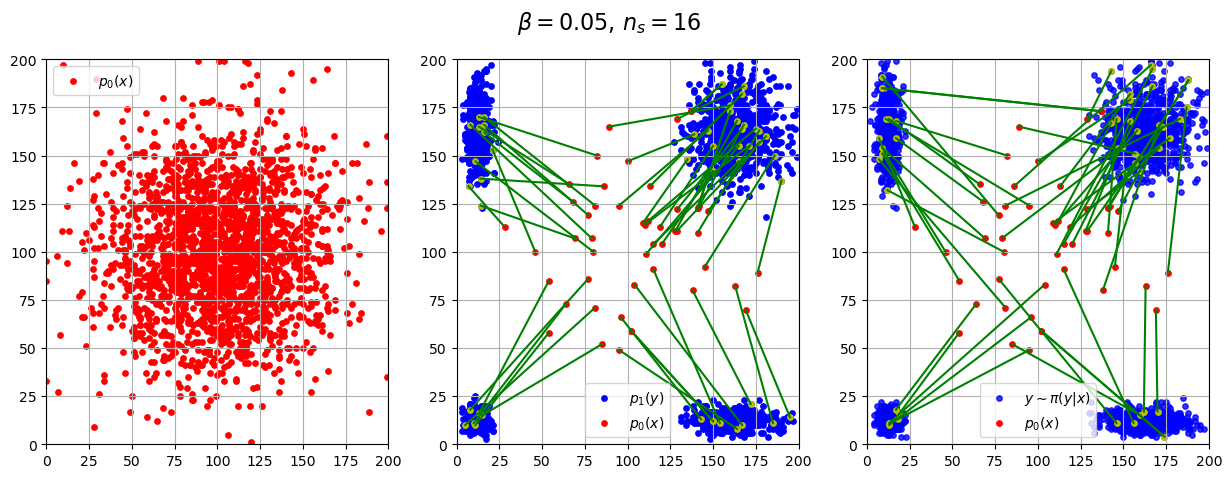

In [8]:
from src.data.prior import Prior

xrange = [0, NUM_CATEGORIES]  
yrange = [0, NUM_CATEGORIES]  
N_TEST = 2000


    
if EXP_TYPE == 'benchmark':
    
    BETA = BETAS[0]
    #prior = Prior(BETA, NUM_CATEGORIES, NUM_STEPS, NUM_SKIP_STEPS, PRIOR_TYPE)
    #bench = BenchmarkDiscreteEOT(P0, DIM, prior, num_potentials=NUM_POTENTIALS, compute_benchmark=False)
    X0_full = torch.load(f'../benchmark_data/X0_benchmark_dim_{DIM}_P0_{P0}.pt')
    X1_full = torch.load(f'../benchmark_data/X1_benchmark_dim_{DIM}_P0_{P0}_prior_{PRIOR_TYPE}_beta_{BETA}.pt')

#else:
#    if P0 == 'gaussian':
#        X0_full = DiscreteGaussianDataset(num_samples=N_TEST, dim=DIM, num_categories=NUM_CATEGORIES, train=False).dataset
#        X1_full = DiscreteSwissRollDataset(num_samples=N_TEST, num_categories=NUM_CATEGORIES).dataset
#    if P0 == 'uniform':
#        X0_full = DiscreteUniformDataset(num_samples=N_TEST, dim=DIM, num_categories=NUM_CATEGORIES, train=False).dataset
#        X1_full = DiscreteSwissRollDataset(num_samples=N_TEST, num_categories=NUM_CATEGORIES).dataset

X0_test =X0_full[-N_TEST:].to(torch.int32).to(DEVICE)
X1_test =X1_full[-N_TEST:].to(torch.int32).to(DEVICE)


#indices_plot = torch.tensor([0, 1, 2, 3], dtype=torch.int32)#torch.randint(0, len(X0_test), (50,))
indices_plot = torch.randint(0, len(X0_test), (50,))

for BETA in BETAS:
    exp_name = f'LightSB_D_beta({BETA})'
    wandb.init(name=exp_name, project=f'LightSB_D_P0_{P0}_PRIOR_TYPE({PRIOR_TYPE})' , config=config, mode=wandb_mode)
    
    prior = Prior(BETA, NUM_CATEGORIES, NUM_STEPS, NUM_SKIP_STEPS, PRIOR_TYPE)
    D = LightSB_D(prior=prior, dim=DIM, num_potentials=NUM_POTENTIALS, distr_init=DIST_INIT, optimizer=None).to(DEVICE)
    
    #if INIT_BY_SAMPLES:
    #    D.init_r_by_samples(Y_sampler.sample(N_POTENTIALS))
    
    D_opt = torch.optim.Adam(D.parameters(), lr=D_LR)
    for step in tqdm(range(N_EPOCHS)):
        D.train()
        D_opt.zero_grad()    

        if EXP_TYPE == 'benchmark':
            indices = torch.randint(high=len(X0_full)-BATCH_SIZE, size=(BATCH_SIZE,))
            X0 = X0_full[indices]
            X1 = X1_full[indices]
        #else:
        #    if P0 == 'gaussian':
        #        X0 = DiscreteGaussianDataset(num_samples=BATCH_SIZE, dim=DIM, num_categories=NUM_CATEGORIES).dataset
        #        X1 = DiscreteSwissRollDataset(num_samples=BATCH_SIZE, num_categories=NUM_CATEGORIES).dataset
        #    
        #    if P0 == 'uniform':
        #        X0 = DiscreteUniformDataset(num_samples=BATCH_SIZE, dim=DIM, num_categories=NUM_CATEGORIES).dataset
        #        X1 = DiscreteSwissRollDataset(num_samples=BATCH_SIZE, num_categories=NUM_CATEGORIES).dataset
             
        X0 = X0.to(torch.int32).to(DEVICE)
        X1 = X1.to(torch.int32).to(DEVICE)
    
        log_potential = D.get_log_v(X1)
        log_C         = D.get_log_c(X0)
        
        D_loss = (-log_potential + log_C).mean()
        wandb.log({'D_loss':D_loss.item()}, step=step)
        D_loss.backward()
        
        D_opt.step()    
    
        if step % 20000==0 or step==N_EPOCHS-1:
            D.eval()
            X1_pred = D.sample(X0_test).detach()#.cpu()
            fig = plot_samples(X0_test, X1_test, X1_pred, indices_plot, BETA, NUM_STEPS, xrange, yrange)
            
            img = fig2img(fig)
            wandb.log({'Plot source->target' : [wandb.Image(img)]}, step=step)

            plt.show()
        